# Initialization

*Why is initialization essential to deep networks?* It turns out that if you do it wrong, **it can lead to exploding or vanishing weights and gradients**. That means that either the weights of the model explode to infinity, or they vanish to 0. And the deeper the network, the harder it becomes to keep the weights at reasonable values. We’ll see why that’s the case in the following sections.And the deeper the network, the harder it becomes to keep the weights at reasonable values.

When initializaing a neural network, there are a few properties we would like to have.

1) The variance of the input should be propagated through the model to the last layer. 
It means, the std deviation for the output neurons should be similar to the 
rest of the layers of the neural network.
2) The varience of the gradient distribution should be equal across layers. Hence, all weight on all layer would be capable of being updated.

In [22]:
## Standard libraries
import os
import json
import math
import numpy as np
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

/tmp/ipykernel_19015/3916073776.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [23]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial4"


# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = (
    torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
)
print("Using device", device)

Using device cpu


In [24]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image => first make them a tensor, then normalize them with mean 0 and std 1
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.2861,), (0.3530,))]
)

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(
    root=DATASET_PATH, train=True, transform=transform, download=True
)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(
    root=DATASET_PATH, train=False, transform=transform, download=True
)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(
    train_set, batch_size=1024, shuffle=True, drop_last=False
)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

In [25]:
print("Mean", (train_dataset.data.float() / 255).mean().item())
print("Std", (train_dataset.data.float() / 255).std().item())

Mean 0.28604060411453247
Std 0.3530242443084717


In [26]:
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Std: {imgs.std().item():5.3f}")

Mean: 0.020
Std: 1.011


In [27]:
class BaseNetwork(nn.Module):

    def __init__(
        self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]
    ):
        super().__init__()

        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_idx in range(1, len(layer_sizes)):
            layers += [
                nn.Linear(
                    in_features=layer_sizes[layer_idx - 1],
                    out_features=layer_sizes[layer_idx],
                ),
                act_fn,
            ]
        layers += [nn.Linear(in_features=layer_sizes[-1], out_features=num_classes)]
        self.layers = nn.ModuleList(layers)

        self.config = {
            "act_fn": act_fn.__class__.__name__,
            "input_size": input_size,
            "num_classes": num_classes,
            "hidden_sizes": hidden_sizes,
        }

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            x = l(x)
        return x

In [28]:
class Identity(nn.Module):
    def forward(self, x):
        return x


act_fn_by_name = {"tanh": nn.Tanh, "relu": nn.ReLU, "identity": Identity}

In [29]:
model = BaseNetwork(act_fn=Identity()).to(device)
model

BaseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Identity()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Identity()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Identity()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): Identity()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [30]:
##############################################################


def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns * 3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index % columns]
        sns.histplot(
            val_dict[key],
            ax=key_ax,
            color=color,
            bins=50,
            stat=stat,
            kde=use_kde and ((val_dict[key].max() - val_dict[key].min()) > 1e-8),
        )  # Only plot kde if there is variance
        key_ax.set_title(
            f"{key} "
            + (
                r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0])
                if len(val_dict[key].shape) > 1
                else ""
            )
        )
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig


##############################################################


def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    ## Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()


##############################################################


def visualize_gradients(model, color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(
        preds, labels
    )  # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {
        name: params.grad.view(-1).cpu().clone().numpy()
        for name, params in model.named_parameters()
        if "weight" in name
    }
    model.zero_grad()

    ## Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")


##############################################################


def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = (
                    feats.view(-1).detach().cpu().numpy()
                )

    ## Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


##############################################################

## Constant initialization

The first initialization we can consider is to initialize all weights with the same constant value. Zero is not a good idea as the propagated gradient would be zero, 
but what if we initialize it slighly larger or smaller than zero?

In [31]:
def const_init(model, c=0.0):
    for _, param in model.named_parameters():
        param.data.fill_(c)


model = BaseNetwork(act_fn=Identity()).to(device)
const_init(model, c=5e-03)

In [32]:
model.layers[0].weight[:4]

tensor([[0.0050, 0.0050, 0.0050,  ..., 0.0050, 0.0050, 0.0050],
        [0.0050, 0.0050, 0.0050,  ..., 0.0050, 0.0050, 0.0050],
        [0.0050, 0.0050, 0.0050,  ..., 0.0050, 0.0050, 0.0050],
        [0.0050, 0.0050, 0.0050,  ..., 0.0050, 0.0050, 0.0050]],
       grad_fn=<SliceBackward0>)

In [33]:
model.layers[0].bias[:4]

tensor([0.0050, 0.0050, 0.0050, 0.0050], grad_fn=<SliceBackward0>)

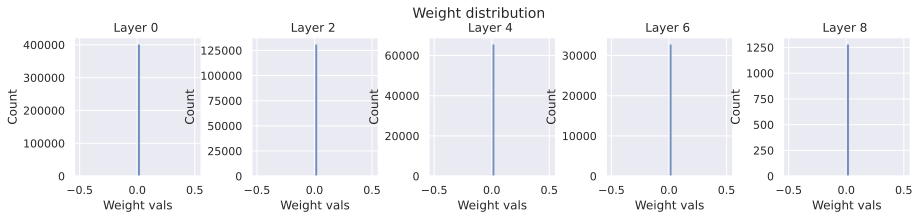

In [34]:
visualize_weight_distribution(model)

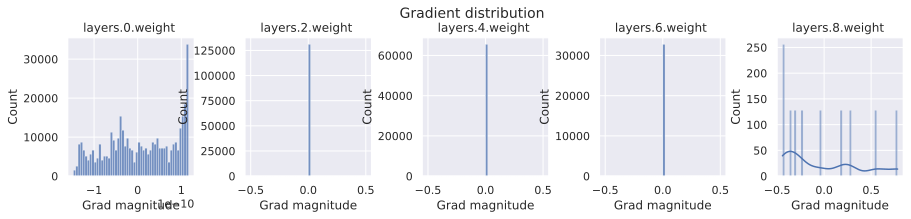

layers.0.weight - Variance: 6.091891982388247e-21
layers.2.weight - Variance: 2.7083389842945504e-35
layers.4.weight - Variance: 0.0
layers.6.weight - Variance: 0.0
layers.8.weight - Variance: 0.16812218725681305


In [35]:
visualize_gradients(model, print_variance=True)

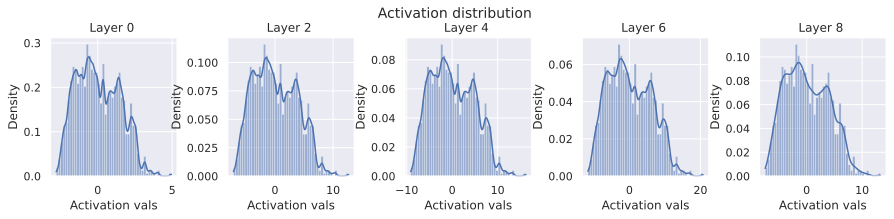

Layer 0 - Variance: 2.0582759380340576
Layer 2 - Variance: 13.489117622375488
Layer 4 - Variance: 22.10056495666504
Layer 6 - Variance: 36.20956802368164
Layer 8 - Variance: 14.831439018249512


In [36]:
visualize_activations(model, print_variance=True)

The gradients of layers (.2, .4 and .6) are basically the same. It seams that is zero but it is a value very close to it.
This is a big problem because those neurons were initialated with the same value and the gradients after backprop are basicaly the same,
which mean that those layers and neurons will learn the same features, there is a symmetry which is not desirable because it reduces the model's capability to learn diverses features.

Furthermore, the variance of the activations are slighly different. And we are looking to maintein the flux of the varience through the network.

## Constant variance

Constant initialization did not work, what if we randomly initializate the weights using a gaussian distribution?

In [37]:
def gauss_init(model, std=0.01):
    for _, param in model.named_parameters():
        param.data.normal_(std)


model = BaseNetwork(act_fn=Identity()).to(device)
gauss_init(model)

In [38]:
model.layers[0].weight[:4]

tensor([[ 1.2556, -1.5981,  0.7969,  ...,  1.0456,  0.7270,  0.1140],
        [ 1.8747,  0.2027,  0.9931,  ..., -0.7952,  1.4358,  0.0201],
        [-0.1872,  1.4849, -0.2828,  ..., -0.6585,  0.6328, -0.3093],
        [ 0.8904,  1.5595, -1.6512,  ...,  0.3900,  0.5142, -0.6927]],
       grad_fn=<SliceBackward0>)

In [39]:
model.layers[0].bias[:4]

tensor([-0.9860,  0.0667,  0.7903, -0.6083], grad_fn=<SliceBackward0>)

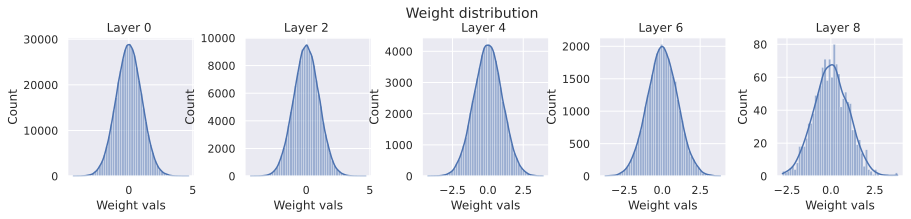

In [40]:
visualize_weight_distribution(model)

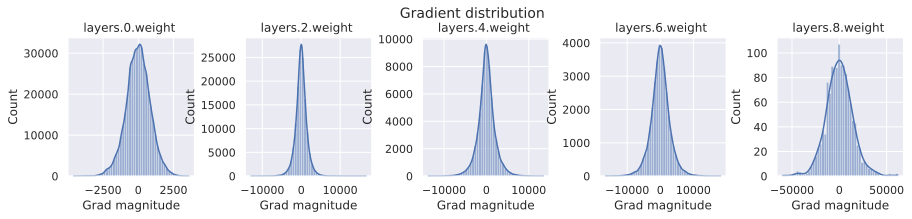

layers.0.weight - Variance: 731193.0
layers.2.weight - Variance: 2148085.5
layers.4.weight - Variance: 4180053.25
layers.6.weight - Variance: 8230875.0
layers.8.weight - Variance: 199099648.0


In [41]:
visualize_gradients(model, print_variance=True)

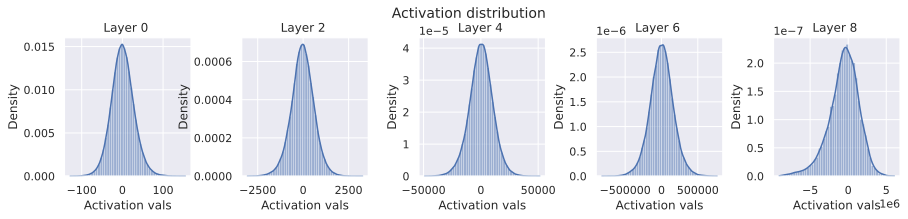

Layer 0 - Variance: 772.1064453125
Layer 2 - Variance: 388658.46875
Layer 4 - Variance: 104524112.0
Layer 6 - Variance: 25696813056.0
Layer 8 - Variance: 3875193487360.0


In [42]:
visualize_activations(model, print_variance=True)

There are two things here, the varience of the gradients in the first layers are smaller than the gradients in the last layers and the variance of the activations tends to increase and explote by layers pass.

## Xavier initialization

We need to sample the weights from a distribution, but we are not sure which one exactly.
We will try to find an optimal initialization from the activation distribution perspective.
The are two requirements:

1) The mean of every activation should be zero (**not all activation functions generate a mean of zero, e.g., ReLU!!**)
2) The varience of the activations should stay the same across every layer

Lets say that we want to desing an initialization for the following layer $l$:

 $$y_{l} = W_{l}x_{l} + b_{l}, \quad y_{l} \in \mathbb{R}^{d_y}, \quad x_{l} \in \mathbb{R}^{d_x}$$

Where:
- $x_{l}$ is a $n_{l}-by-1$ vector that represents the activations of the previous layer $y_{l-1}$ that were passed through an activation function $f$, i.e., $x_{l} = f(y_{l-1})$.
- $W_{l}$ is a $d_{l}-by-n_{l}$ matrix of all connections (weights) from layer $l-1$ and layer $l$.
- $b_{l}$ is a vector of biases of layer $l$ (usually initalizated at 0).
- and $y_{l}$ is the vector of the activations before passing through the activation function.


There are some hyphotesis made on those vectors and matrixes:

- The initialization of elements in $W_{l}$ are independent and share the same distribution.
- Likewise, elements of $x_{l}$ are mutually independent and share the same distribution.
- $x_{l}$ and $W_{l}$ are mutually independent.

Our goal is that the varience of $y_l$ is the same as the input, i.e. $Var(y_l) = Var(x_l) = \sigma_x^2$ and a mean of zero, i.e. $\mu = 0$. We asume that $x$ has a mean of zero
as result of passing through the activation function $f$ and we do not take into account the vector bias $b$.

$$
Var(y_l)= Var(W_{l}x_{l}) = \sigma_{x_l}^2
$$


Lets reduce the problem and study the output of a neuron $i$ in layer $l$ without the term bias $b$:

$$y_i^l = \sum_{j}w_{ij}^{l}x_{j}^{l}$$ 

    
$$
Var(y_l)= Var(\sum_{j}w_{ij}x_{j}) = \sigma_x^2 
$$


We need to compute the varience of the weights, $Var(w_{ij})$:

$$
 = \sum_{j}Var(w_{ij}x_{j})
$$

Given two independent variables, the varience of their product is given by the following equivalence: $Var(X \cdot Y) = \mathbb{E}(Y)^2Var(X) + \mathbb{E}(X)^2Var(Y) + Var(X)Var(Y)$. $\mathbb{E}$ represents the expected value of a variable. In this case, the expected value of $x$ and $y$ is $0$ because is one of our statements.

$$
 = \sum 0 + 0 + Var(w_{ij})Var(x_{j})
$$

As varience is equal for each neuron, i.e., $d_x$ elements.

$$
 = d_x \cdot Var(w_{ij}) \cdot Var(x_{j})
$$

$$
 = d_x \cdot \sigma_x^2 \cdot Var(w_{ij})
$$


$$
 \cancel{\sigma_x^2} = \cancel{\sigma_x^2} \cdot d_x \cdot Var(w_{ij})
$$


$$
 \Rightarrow Var(w_{ij}) = \sigma^2_W = \frac{1}{d_x}
$$


$$
 \Rightarrow \sigma^W = \frac{1}{\sqrt{d_x}}
$$


Thus, we should initialize the weight distribution with a varience of the inverse of the input dimension $d_x$, in 
other words, the weights should follow a normal distribution with a standar deviation equal to the inverse of the root of the dimention $d_x$.

In [43]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1 / math.sqrt(param.shape[1]))


model = BaseNetwork(act_fn=Identity()).to(device)
equal_var_init(model)

In [44]:
model.layers[0].weight[:4]

tensor([[-0.0365, -0.0418,  0.0493,  ...,  0.0292,  0.0067, -0.0036],
        [-0.0174, -0.0130, -0.0273,  ...,  0.0356, -0.0319, -0.0173],
        [ 0.0029, -0.0124,  0.0356,  ..., -0.0534, -0.0499,  0.0105],
        [ 0.0305, -0.0222,  0.0085,  ..., -0.0375, -0.0454, -0.0167]],
       grad_fn=<SliceBackward0>)

In [45]:
model.layers[0].bias[:4]

tensor([0., 0., 0., 0.], grad_fn=<SliceBackward0>)

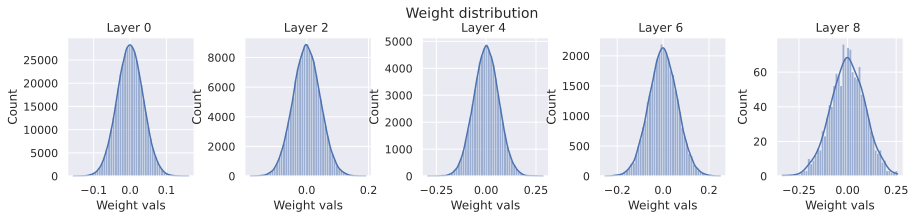

In [46]:
visualize_weight_distribution(model)

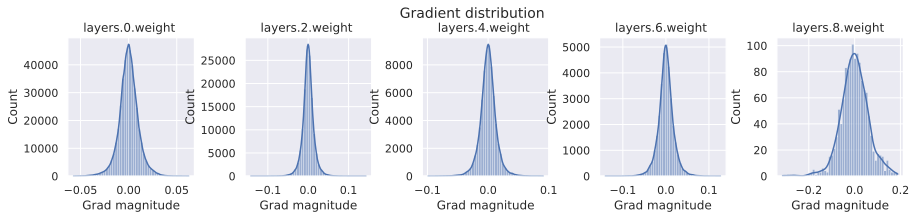

layers.0.weight - Variance: 0.00010186272993450984
layers.2.weight - Variance: 0.00019615005294326693
layers.4.weight - Variance: 0.0001796914148144424
layers.6.weight - Variance: 0.0003215362667106092
layers.8.weight - Variance: 0.003684979397803545


In [47]:
visualize_gradients(model, print_variance=True)

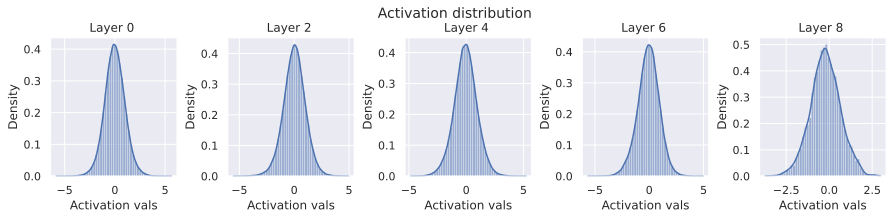

Layer 0 - Variance: 1.0121690034866333
Layer 2 - Variance: 1.0003920793533325
Layer 4 - Variance: 0.9879134297370911
Layer 6 - Variance: 0.9820103645324707
Layer 8 - Variance: 0.75328528881073


In [48]:
visualize_activations(model, print_variance=True)